<a href="https://colab.research.google.com/github/Khuks/Customer-Churn-Prediction/blob/main/Main_Project_Customer_Churn_Prediction_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Churn Classification** 
By Nokwanda Sihlongonyane

This is a machine learning project for the prediction if a User would churn or not. The data set contain several features, with a need application of a classification model.

so let's start importing needed libraries

In [67]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
import plotly.express as px 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score,recall_score 
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN 
from imblearn.combine import SMOTETomek 
from google.colab import files
import io
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Train.csv')

Data Exploration

In [ ]:
print('Data Information Table')
display(data.info(verbose = True,show_counts=True))
print('Data Head Table')
display(data.head())
print('Data Describe Information Table')
display(data.describe())
print(f'\n Data Shape: {data.shape}')
print(f'Data Columns {data.columns}')

In [ ]:
missing = (round(((data.isnull().sum()/len(data.index))*100),2).to_frame('null')).sort_values('null', ascending=False)

In [ ]:
missing

**Unique Values**

In [ ]:
for column in data.columns : 
    print('Number of unique data for {0} is {1}'.format(column , len(data[column].unique())))
    print('unique data for {0} is {1}'.format(column , data[column].unique()))
    print('=====================================')

**Needed Functions For Visualization**

In [ ]:
def PlotMultiplePie(df,categorical_features = None,dropna = False):
    # set a threshold of 30 unique variables, more than 50 can lead to ugly pie charts 
    threshold = 30
    
    # if user did not set categorical_features 
    if categorical_features == None: 
        categorical_features = df.select_dtypes(['object','category']).columns.to_list()
        print(categorical_features)
    
    # loop through the list of categorical_features 
    for cat_feature in categorical_features: 
        num_unique = df[cat_feature].nunique(dropna = dropna)
        num_missing = df[cat_feature].isna().sum()
        if num_unique <= threshold:
            print('Chart for: ', cat_feature)
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            fig = px.bar(df[cat_feature].value_counts(dropna = dropna), x=cat_feature, 
                 y = df[cat_feature].value_counts(dropna = dropna).index,title = cat_feature,template='ggplot2')
    
            fig.show()
        else: 
            print('Chart for ',cat_feature,' is unavailable due high number of Unique Values ')
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            print('\n')
    return

def plotForContinousFeaturesInDataSet(data):
    continous_features = data.select_dtypes(['float64']).columns.to_list()
    for cont_feature in continous_features: 
        plt.figure()
        plt.title(cont_feature)
        ax = sns.distplot(data[cont_feature])
    return
        
def plotForDiscreteFeaturesInDataSet(data):
    discrete_features = data.select_dtypes(['int64']).columns.to_list()
    for disc_feature in discrete_features: 
        plt.figure()
        plt.title(disc_feature)
        ax = sns.distplot(data[disc_feature],kde = False)
    return

**Visualization**

In [ ]:
PlotMultiplePie(data)

In [ ]:
plotForContinousFeaturesInDataSet(data)

In [ ]:
plotForDiscreteFeaturesInDataSet(data)

**Data Preprocessing**

Using label encoding for the categorical data

In [ ]:
def make_label_encoder(original_feature , new_feature) : 
    enc  = LabelEncoder()
    enc.fit(data[original_feature])
    data[new_feature] = enc.transform(data[original_feature])
    data.drop([original_feature],axis=1, inplace=True)

In [ ]:
make_label_encoder('REGION', 'REGION_CODE')

In [ ]:
make_label_encoder('TOP_PACK', 'TOP_PACK_CODE')

In [ ]:
data = data.drop(['MRG','user_id'], axis=1)
data['TENURE'] = data['TENURE'].map({'K > 24 month': 24, 'I 18-21 month': 18, 'H 15-18 month': 15, 'G 12-15 month':12,
                                             'J 21-24 month': 21, 'F 9-12': 9, 'E 6-9 month':6, 'D 3-6 month':3})

Replacing the null values with mean

In [ ]:
def replaceDataNullsWithMean(data):
    for item in data:
        data[item].replace([np.inf, -np.inf,], np.nan, inplace=True)
        if item in list(missing.index[missing['null'] > 0]):
            data[item].fillna((data[item].mean()), inplace=True)
            
    return data

In [ ]:
replaceDataNullsWithMean(data)

In [ ]:
data = data.reset_index()

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
clean_dataset(data)

In [ ]:
print('Data Information Table')
display(data.info(verbose = True,show_counts=True))

Splitting data into train set(75%) and test set (25%)

In [ ]:
xData = data.drop(['CHURN'], axis = 1)
yData = data.CHURN
x_train,x_test,y_train,y_test = train_test_split(xData, yData,test_size=0.25, random_state=42, shuffle=True, stratify=yData)

In [ ]:
stdScaler = StandardScaler()
x_train_scaled = stdScaler.fit_transform(x_train)
x_test_scaled = stdScaler.transform(x_test)

In [ ]:
#undersampler = RandomUnderSampler()
#oversampler = RandomOverSampler()
#smote = SMOTE()
sme = SMOTEENN(random_state=42)
smt = SMOTETomek(random_state=42)
#samplers = [undersampler, oversampler, smote]
samplers = [smt,sme]
model = LogisticRegression()
def train_model_on_sampling_techniques(model, samplers, x_train, y_train):
    for sampler in samplers:
        x_train_samp, y_train_samp = sampler.fit_resample(x_train, y_train)
        pipeline = make_pipeline(StandardScaler(), model)
        scores = cross_val_score(pipeline, x_train_samp, y_train_samp, scoring='recall')
        print("The recall score for LR using {0} is {1} (+/- {2})".format(str(sampler), round(scores.mean(), 3), round(scores.std(), 2)))

In [ ]:
#train_model_on_sampling_techniques(model, samplers, x_train, y_train)

In [ ]:
#x_train_samp, y_train_samp = smote.fit_resample(x_train, y_train)
#x_train_ovr, y_train_ovr = oversampler.fit_resample(x_train, y_train)
#x_train_und, y_train_und = undersampler.fit_resample(x_train, y_train)

#x_train_sme, y_train_sme = sme.fit_resample(x_train, y_train)
#x_train_smt, y_train_smt = smt.fit_resample(x_train, y_train)

## Feature Importance 

Before fitting the training dataset, we need to identify the most important feature in our dataset.

We will use Random Forest Classifier to determine the most important feature.

In [ ]:
# import Random Forest classifier

from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
# create the classifier with n_estimators = 100

clf = RandomForestClassifier(n_estimators=100,random_state=0)


In [57]:
# fit the model to the training set

clf.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

Now, I will use the feature importance variable to see feature importance scores.

In [58]:
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

feature_scores
     

index             0.369827
REGULARITY        0.171725
REGION_CODE       0.155739
TOP_PACK_CODE     0.067797
ON_NET            0.040280
DATA_VOLUME       0.031478
ORANGE            0.030829
REVENUE           0.027086
ARPU_SEGMENT      0.021682
MONTANT           0.019215
FREQUENCE_RECH    0.015786
FREQ_TOP_PACK     0.014911
FREQUENCE         0.013521
TIGO              0.009366
TENURE            0.004556
ZONE1             0.003583
ZONE2             0.002619
dtype: float64

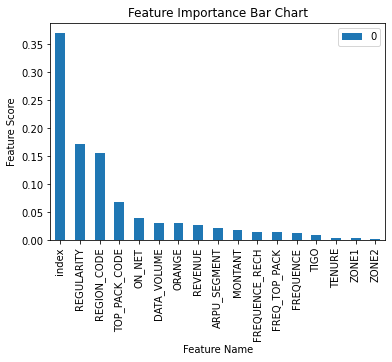

In [59]:
df = pd.DataFrame(feature_scores)
df.plot(kind='bar')
plt.title("Feature Importance Bar Chart")
plt.xlabel("Feature Name")
plt.ylabel("Feature Score")
plt.show()

## Model Building

We will implimant the following models. We will first implement them first without using any sampling algorithms. Then implememnt them through using the 
SMOTEENN and the SMOTETomek.

- Grid Search
- Decesion Tree


## a) Without Sampling Algorithm
### 1. Decesion Tree

In [60]:
# Instantiate the grid search model
dtree_model = DecisionTreeClassifier()

In [61]:
dtree_model.fit(x_train,y_train)

DecisionTreeClassifier()

In [62]:
pred_dtree=dtree_model.predict(x_test)
pred_dtree

array([0, 0, 0, ..., 0, 0, 0])

#### Evaluation Metrics For Decision Tree

In [63]:
print('MAE:', metrics.mean_absolute_error(y_test,pred_dtree))
print('MSE:', metrics.mean_squared_error(y_test,pred_dtree))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,pred_dtree)))

MAE: 0.1647638052255646
MSE: 0.1647638052255646
RMSE: 0.4059110804419665


#### Accuracy Score For Decesion Tree


Now calculate how accurate our predictions are by calculating the accuracy.

In [64]:
score_dtree =accuracy_score(pred_dtree,y_test)*100 
score_dtree

83.52361947744353

#### Confusion Metrix For Decision

Text(0.5, 1.0, 'Accuracy Score: 83.52361947744353 %')

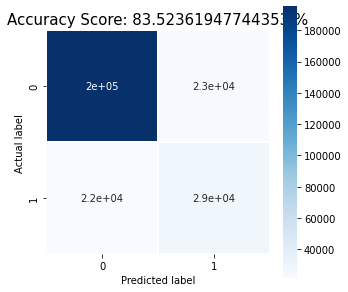

In [68]:
cm = confusion_matrix(y_test,pred_dtree)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0} %'.format(dtree_model.score(x_test,y_test)*100)
plt.title(all_sample_title, size = 15)

### 2. Grid Search Algorithm

In [80]:
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}

grid_search = GridSearchCV(estimator = dtree_model, 
                           param_grid = param_grid, 
                           scoring='roc_auc',
                           cv = 5, 
                           verbose = 1)


In [81]:
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [82]:
pred_gsearch=grid_search.predict(x_test)
pred_gsearch

array([0, 0, 1, ..., 0, 0, 0])

#### Evaluation Metrics For Grid Search Algorithm

In [83]:
print('MAE:', metrics.mean_absolute_error(y_test,pred_gsearch))
print('MSE:', metrics.mean_squared_error(y_test,pred_gsearch))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,pred_gsearch)))

MAE: 0.12204546726096119
MSE: 0.12204546726096119
RMSE: 0.3493500640631989


#### Accuracy Score For Grid Search

Now calculate how accurate our predictions are by calculating the accuracy.

In [84]:
score_gsearch =accuracy_score(pred_gsearch,y_test)*100 
score_gsearch

87.79545327390387

#### Confusion Metrix For Grid Search

Text(0.5, 1.0, 'Accuracy Score: 92.8952351930382 %')

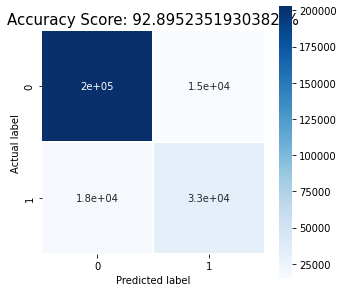

In [90]:
cm = confusion_matrix(y_test,pred_gsearch)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0} %'.format(grid_search.score(x_test,y_test)*100)
plt.title(all_sample_title, size =15)

## b) Sampling Algorithms

In [ ]:
x_train_sme, y_train_sme = sme.fit_resample(x_train, y_train)
x_train_smt, y_train_smt = smt.fit_resample(x_train, y_train)

## SMOTEENN Sampling Algorithm

### 1. Decision Tree

In [ ]:
# Instantiate the grid search model
dtree_model1 = DecisionTreeClassifier()
dtree_model1.fit(x_train_sme,y_train_sme)


In [ ]:
pred_dtree1=dtree_model.predict(x_test_sme)
pred_dtree1

### Evaluation Metrics For Decision Tree

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test_sme,pred_dtree1))
print('MSE:', metrics.mean_squared_error(y_test_sme,pred_dtree1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_sme,pred_dtree1)))

### Accuracy Score For Decesion

Now calculate how accurate our predictions are by calculating the accuracy.

In [ ]:
score_dtree1 =accuracy_score(pred_dtree1,y_test_sme)*100 
score_dtree1

### Confusion Metrix For Decision

In [ ]:
cm = confusion_matrix(y_test_sme,pred_dtree1)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0} %'.format(dtree_model.score(x_test_sme,y_test_sme)*100)
plt.title(all_sample_title, size = 15)

### 2. Grid Search Algorithm

In [ ]:
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}

grid_search1 = GridSearchCV(estimator = dtree_model, 
                           param_grid = param_grid, 
                           scoring='roc_auc',
                           cv = 5, 
                           verbose = 1)


In [ ]:
grid_search1.fit(x_train_sme,y_train_sme)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [ ]:
pred_gsearch1=grid_search1.predict(x_test_sme)
pred_gsearch1

array([0, 0, 1, ..., 0, 0, 0])

#### Evaluation Metrics For Grid Search Algorithm

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test_sme,pred_gsearch1))
print('MSE:', metrics.mean_squared_error(y_test_sme,pred_gsearch1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_sme,pred_gsearch1)))

MAE: 0.12204546726096119
MSE: 0.12204546726096119
RMSE: 0.3493500640631989


#### Accuracy Score For Grid Search

Now calculate how accurate our predictions are by calculating the accuracy.

In [ ]:
score_gsearch1 =accuracy_score(pred_gsearch1,y_test_sme)*100 
score_gsearch1

87.79545327390387

#### Confusion Metrix For Grid Search

Text(0.5, 1.0, 'Accuracy Score: 92.8952351930382 %')

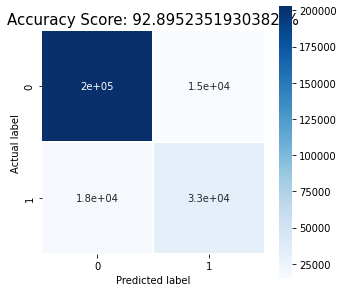

In [ ]:
cm = confusion_matrix(y_test_sme,pred_gsearch1)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0} %'.format(grid_search.score(x_test_sme,y_test_sme)*100)
plt.title(all_sample_title, size =15)

## SMOTETomek Sampling Algorithm

### 1. Decision Tree

In [ ]:
# Instantiate the grid search model
dtree_model2 = DecisionTreeClassifier()
dtree_model2.fit(x_train_smt,y_train_smt)


In [ ]:
pred_dtree2=dtree_model.predict(x_test_smt)
pred_dtree2

### Evaluation Metrics For Decision Tree

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test_smt,pred_dtree2))
print('MSE:', metrics.mean_squared_error(y_test_smt,pred_dtree2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_smt,pred_dtree2)))

### Accuracy Score For Decesion

Now calculate how accurate our predictions are by calculating the accuracy.

In [ ]:
score_dtree2 =accuracy_score(pred_dtree2,y_test_smt)*100 
score_dtree2

### Confusion Metrix For Decision

In [ ]:
cm = confusion_matrix(y_test_smt,pred_dtree2)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0} %'.format(dtree_model2.score(x_test_smt,y_test_smt)*100)
plt.title(all_sample_title, size = 15)

### 2. Grid Search Algorithm

In [ ]:
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}

grid_search2 = GridSearchCV(estimator = dtree_model, 
                           param_grid = param_grid, 
                           scoring='roc_auc',
                           cv = 5, 
                           verbose = 1)


In [ ]:
grid_search2.fit(x_train_smt,y_train_smt)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [ ]:
pred_gsearch2=grid_search2.predict(x_test_smt)
pred_gsearch2

array([0, 0, 1, ..., 0, 0, 0])

#### Evaluation Metrics For Grid Search Algorithm

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test_smt,pred_gsearch2))
print('MSE:', metrics.mean_squared_error(y_test_smt,pred_gsearch2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_smt,pred_gsearch2)))

MAE: 0.12204546726096119
MSE: 0.12204546726096119
RMSE: 0.3493500640631989


#### Accuracy Score For Grid Search

Now calculate how accurate our predictions are by calculating the accuracy.

In [ ]:
score_gsearch2 =accuracy_score(pred_gsearch2,y_test_smt)*100 
score_gsearch2

87.79545327390387

#### Confusion Metrix For Grid Search

Text(0.5, 1.0, 'Accuracy Score: 92.8952351930382 %')

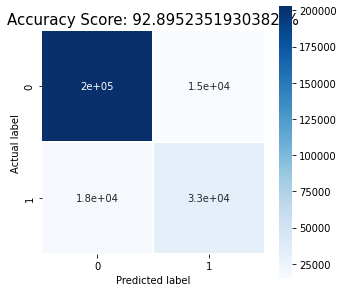

In [ ]:
cm = confusion_matrix(y_test_smt,pred_gsearch2)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0} %'.format(grid_search.score(x_test_smt,y_test_smt)*100)
plt.title(all_sample_title, size =15)